# Check Algorithm Profits

In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def trasform_ratios_to_probs(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        df_copy[column] = (1/df_copy[column])
    normalization_factor = df_copy.sum(axis = 1)
    for column in df_copy.columns:
        df_copy[column] /= normalization_factor
    return df_copy

def get_naive_predictions(df):
    return pd.Series(np.array(df).argmax(axis = 1),index = df.index)

def calc_rolling_mean(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).mean())[0:-1]
    return pd.Series(temp_list,index = series.index)

def calc_rolling_sum(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).sum())[0:-1]
    return pd.Series(temp_list,index = series.index)

def get_optimal_bet_ratio(df,bet_houses,pred):
    dic = {0:"D",1:"H",2:"A"}
    temp_pred = pred.map(dic)
    temp = []
    for index in temp_pred.index:
        new_list = [x + temp_pred.at[index] for x in bet_houses]
        temp.append(df.loc[index][new_list].max())
    return pd.Series(temp,index = df.index)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [43]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_leagues = features["league"].unique()
        
    for league in all_leagues:
        all_seasons = features[features["league"] == league]["season"].unique()
        
        num_of_seasons    = len(all_seasons)
        test_num_seasons  = round(num_of_seasons*test_size)
        train_num_seasons = num_of_seasons-test_num_seasons
        
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

info_list = ["league","season"]

In [44]:
matches = pd.read_csv("databases/my_matches_db.csv",encoding='latin-1', index_col = [0], skipinitialspace = True)
matches.head()

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.0,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.5,4.5,5.5,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.0,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.5,5.5,6.0,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.0,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.6,3.3,3.8,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.0,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.4,3.2,3.5,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.0,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.4,3.2,3.5,1


In [45]:
all_models = ["KNeighborsClassifier","LogisticRegression","RandomForestClassifier","nn_model","lstm_model","final_soft_decision"]

my_predictions = {}

for model in all_models:
    my_predictions[model] = pd.read_csv("databases/my_predictions/" + model + ".csv", index_col = [0], skipinitialspace = True)
    
my_predictions[model].head()

,MYD,MYH,MYA
800,0.233947,0.539471,0.226582
801,0.256329,0.259654,0.484017
802,0.187169,0.656947,0.155885
803,0.263451,0.511100,0.225450
804,0.230223,0.575317,0.194460


### Betting odds features

In [46]:
b365_features = ["B365D","B365H","B365A"]
wh_features   = ["WHD","WHH","WHA"]
vc_features   = ["VCD","VCH","VCA"]
my_features   = ["MYD","MYH","MYA"]

bet_houses    = ["B365","WH","VC"]

current_bet   = b365_features

In [47]:
matches[my_features] = my_predictions["lstm_model"]
#["KNeighborsClassifier","LogisticRegression","RandomForestClassifier",
#"nn_model","lstm_model","final_soft_decision"]

In [48]:
new_matches = matches.dropna(axis = 0)

In [49]:
new_matches

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw,MYD,MYH,MYA
800,England Premier League,2010/2011,5,Manchester United,Liverpool,3 - 2,8.0,0.666667,3.0,0.0,...,5.50,5.50,5.50,3.50,3.50,3.75,1,0.256170,0.485211,0.258619
801,England Premier League,2010/2011,5,Sunderland,Arsenal,1 - 1,5.0,0.416667,10.0,0.0,...,1.67,1.67,1.67,3.70,3.50,3.75,0,0.292051,0.336386,0.371564
802,England Premier League,2010/2011,5,Tottenham Hotspur,Wolverhampton Wanderers,3 - 1,5.0,0.416667,11.0,0.0,...,8.50,8.50,8.00,4.50,4.20,4.40,1,0.218962,0.584630,0.196408
803,England Premier League,2010/2011,5,Aston Villa,Bolton Wanderers,1 - 1,6.0,0.500000,7.0,0.0,...,4.50,4.50,4.75,3.60,3.50,3.50,0,0.250117,0.501084,0.248799
804,England Premier League,2010/2011,5,Everton,Newcastle United,0 - 1,2.0,0.166667,19.0,0.0,...,6.00,5.50,6.00,3.75,3.75,3.75,2,0.238566,0.539566,0.221869
805,England Premier League,2010/2011,5,Blackburn Rovers,Fulham,1 - 1,4.0,0.333333,15.0,0.0,...,4.00,3.60,3.80,3.30,3.30,3.30,0,0.267971,0.473354,0.258674
806,England Premier League,2010/2011,5,West Bromwich Albion,Birmingham City,3 - 1,4.0,0.333333,16.0,0.0,...,3.25,3.20,3.25,3.30,3.25,3.30,1,0.275272,0.447961,0.276767
807,England Premier League,2010/2011,5,Stoke City,West Ham United,1 - 1,3.0,0.250000,18.0,1.0,...,4.20,4.00,4.33,3.40,3.30,3.60,0,0.268037,0.455269,0.276695
808,England Premier League,2010/2011,5,Wigan Athletic,Manchester City,0 - 2,4.0,0.333333,17.0,0.0,...,1.73,1.73,1.80,3.60,3.60,3.50,2,0.294193,0.341103,0.364704
809,England Premier League,2010/2011,5,Chelsea,Blackpool,4 - 0,12.0,1.000000,1.0,4.0,...,26.00,21.00,29.00,9.00,9.00,10.00,1,0.082874,0.860495,0.056631


###  Features with nan values

In [50]:
max_bet_per_match = 1000

In [51]:
matches_betting_odds_features = new_matches[info_list + current_bet].dropna(axis = 0)

if current_bet != my_features:
    matches_betting_odds_features[current_bet] = trasform_ratios_to_probs(matches_betting_odds_features[current_bet])
    
new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

matches_betting_odds_features["predictions"] = new_matches["predictions"]
matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])


matches_betting_odds_features.head()

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,league,season,B365D,B365H,B365A,predictions,real_score,right_wrong,bet_ratio
800,England Premier League,2010/2011,0.270622,0.557164,0.172214,1,1,1,1.73
801,England Premier League,2010/2011,0.257182,0.173013,0.569805,2,0,0,1.67
802,England Premier League,2010/2011,0.210806,0.677591,0.111603,1,1,1,1.44
803,England Premier League,2010/2011,0.263158,0.526316,0.210526,1,0,0,1.83
804,England Premier League,2010/2011,0.253819,0.587544,0.158637,1,2,0,1.62


In [52]:
new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)

In [53]:
new_matches_betting_odds_features.head()

,league,season,B365D,B365H,B365A,right_wrong,bet_ratio
800,England Premier League,2010/2011,0.270622,0.557164,0.172214,1,1.73
801,England Premier League,2010/2011,0.257182,0.173013,0.569805,0,1.67
802,England Premier League,2010/2011,0.210806,0.677591,0.111603,1,1.44
803,England Premier League,2010/2011,0.263158,0.526316,0.210526,0,1.83
804,England Premier League,2010/2011,0.253819,0.587544,0.158637,0,1.62


In [54]:
calc_rolling_mean(new_matches_betting_odds_features,"right_wrong").tail()

13251    0.536781
13252    0.536609
13253    0.536437
13254    0.536585
13255    0.536734
dtype: float64

In [55]:
new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
new_lables   = new_matches_betting_odds_features[info_list + ["right_wrong"]]

In [56]:
new_features.columns = ['league', 'season', '0', '1', '2', 'bet_ratio']

### Spliting the data 

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.40
seed        = None#101

In [59]:
X_train_outer, X_test_outer, y_train_outer, y_test_outer = get_split_func(split_mode)(new_features, new_lables, test_size = test_size, random_state = seed)

**England Premier League:**

train_leagues = ['2010/2011']
test_leagues  = ['2011/2012']


**France Ligue 1:**

train_leagues = ['2015/2016']
test_leagues  = ['2013/2014']


**Germany 1. Bundesliga:**

train_leagues = ['2014/2015']
test_leagues  = ['2010/2011']


**Netherlands Eredivisie:**

train_leagues = ['2015/2016']
test_leagues  = ['2011/2012']


**Spain LIGA BBVA:**

train_leagues = ['2010/2011']
test_leagues  = ['2013/2014']


In [60]:
X_train_outer = X_train_outer[["0","1","2","bet_ratio"]]
X_test_outer  = X_test_outer[["0","1","2","bet_ratio"]]
y_train_outer = y_train_outer["right_wrong"]
y_test_outer  = y_test_outer["right_wrong"]

In [61]:
X_train_outer.drop("bet_ratio",axis = 1,inplace = True)

In [62]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = 101)

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
logmodel = LogisticRegression()
logmodel.fit(X_train_inner,y_train_inner)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train_inner,y_train_inner)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [66]:
chosen_model = logmodel
predictions  = chosen_model.predict(X_test_inner)

In [67]:
from sklearn.metrics import classification_report,confusion_matrix

In [68]:
printmd('**classification_report:**')
print(classification_report(y_test_inner,predictions))
printmd('**confusion_matrix:**')
print(confusion_matrix(y_test_inner,predictions))

**classification_report:**

             precision    recall  f1-score   support

          0       0.57      0.32      0.41       222
          1       0.56      0.78      0.65       246

avg / total       0.56      0.56      0.54       468



**confusion_matrix:**

[[ 72 150]
 [ 55 191]]


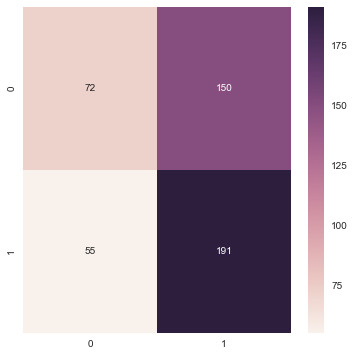

In [69]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_inner,predictions),annot=True, fmt="d")

In [70]:
coeff_df = pd.DataFrame(logmodel.coef_.T,X_train_inner.columns)
coeff_df

,0
0,-2.821893
1,1.807698
2,0.854108


In [71]:
def get_optimal_bet(df,model,max_bet):
    #return pd.Series(df.max(axis=1)*max_bet,index = df.index)
    #return pd.Series(model.predict(df)*df.max(axis=1)*max_bet,index = df.index)
    return pd.Series(np.maximum((model.predict_proba(df) - 0.5)*2,0).T[1]*model.predict(df)*df.max(axis=1)*max_bet,index = df.index)

In [72]:
X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),chosen_model,max_bet_per_match)

In [73]:
X_test_outer["right_wrong"] = y_test_outer

In [74]:
X_test_outer.head()

,0,1,2,bet_ratio,bet,right_wrong
1180,0.278580,0.495902,0.225517,2.00,35.359031,0
1181,0.278580,0.225517,0.495902,1.91,0.000000,0
1182,0.264368,0.528736,0.206897,1.83,59.599098,0
1183,0.235955,0.629213,0.134831,1.53,132.230920,1
1184,0.249688,0.145971,0.604340,1.62,0.000000,0


In [75]:
games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]

In [76]:
calc_rolling_mean(games_worth_betting,"right_wrong").tail()

13251    0.571173
13252    0.570662
13253    0.570152
13254    0.570536
13255    0.570919
dtype: float64

In [77]:
games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]

all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
all_bets[bet_info]               = games_worth_betting[bet_info]
all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

all_bets.reset_index(drop=True,inplace=True)

all_bets.head()

,season,stage,home_team_name,away_team_name,score,predictions,right_wrong,bet_ratio,bet,profit,profit_through_time,invest_through_time
0,2011/2012,5,Aston Villa,Newcastle United,1 - 1,1,0,2.00,35.359031,-35.359031,0.000000,0.000000
1,2011/2012,5,Bolton Wanderers,Norwich City,1 - 2,1,0,1.83,59.599098,-59.599098,-35.359031,35.359031
2,2011/2012,5,Everton,Wigan Athletic,3 - 1,1,1,1.53,132.230920,70.082388,-94.958129,94.958129
3,2011/2012,5,Manchester United,Chelsea,3 - 1,1,1,1.85,49.631422,42.186708,-24.875741,227.189050
4,2011/2012,5,Tottenham Hotspur,Liverpool,4 - 0,1,1,2.70,2.273907,3.865643,17.310967,276.820471


In [79]:
print("Mean Bet             =", all_bets["bet"].mean(),"$")
print("Max  Bet             =", all_bets["bet"].max(),"$")
print("Min  Bet             =", all_bets["bet"].min(),"$","\n")
print("Mean Profit          =", all_bets["profit"].mean(),"$")
print("Max  Profit          =", all_bets["profit"].max(),"$")
print("Min  Profit          =", all_bets["profit"].min(),"$","\n")
print("Total Money Invested =", all_bets["bet"].sum(),"$")
print("Profits              =", all_bets["profit"].sum(),"$")
print("Profit Percentage    =",(all_bets["profit"].sum()/all_bets["bet"].sum())*100,"%")

Mean Bet             = 104.00924006504454 $
Max  Bet             = 527.320550505 $
Min  Bet             = 0.0583269813589 $ 

Mean Profit          = -1.9483947348765402 $
Max  Profit          = 94.0399152542 $
Min  Profit          = -477.210747515 $ 

Total Money Invested = 116698.36735297997 $
Profits              = -2186.098892531478 $
Profit Percentage    = -1.8732900400561212 %


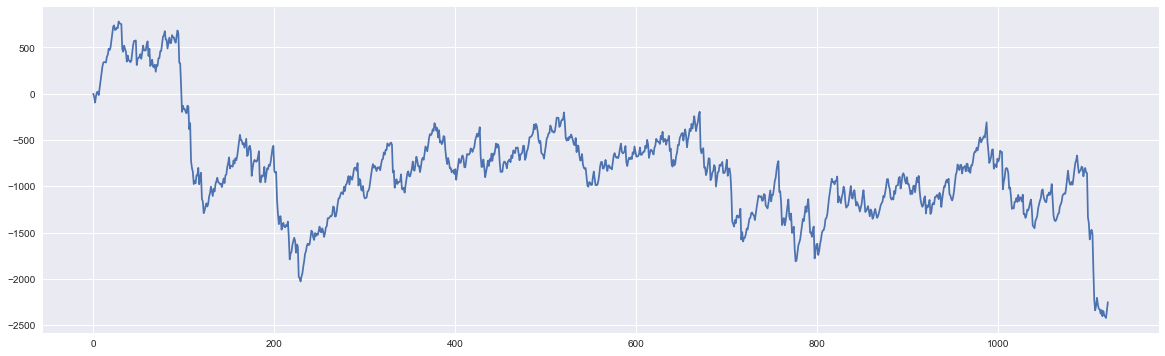

In [80]:
plt.figure(figsize=(20, 6))
plt.plot(all_bets.index,all_bets["profit_through_time"])